# Visualizing the dense annotations

MammAlps contains dense annotations for every individuals in the dataset.   
At every frame, any individual is localized by a `bounding_box`, which is associated to this individual `track_id`.  
Each `bouding_box` contains multiple attributes:
* `species`: a non-mutable attribute correspoding to the indivudal species name
* `activity`: a mutable attribute describing the individual's high-level behavior
* `action`: a mutable attribute describing the individual's low-level behavior
* `action2`: there can be up to two simultaneous actions (e.g., *standing_head_up* \& *vocalizing*)

In this demo notebook, we load the annotations of a video and visualize them using the ``supervision`` library.

In [1]:
import json
from pathlib import Path
from typing import Dict
import sys

import cv2
import ffmpeg
import supervision as sv
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from IPython.display import Video

sys.path.append("..")
from mammalps.visualization.generate_visualization_videos import supervision_from_json

## Data paths

In [2]:
video_path = "../resources/demo_video.mp4"
annotations_path = "../resources/demo_annotations.json"

## Loading resources

In [3]:
Video(str(video_path), width=920, height=540)

In [4]:
with open(annotations_path, "r") as jf:
    annotations = json.load(jf)

# Header section of each annotation file
print("JSON file fields:", list(annotations.keys()))
print("info field:")
print(json.dumps(annotations["info"], indent=2))

JSON file fields: ['info', 'frames']
info field:
{
  "site_id": "S1",
  "cam_id": "C1",
  "event_id": "E4",
  "file_id": "S1_C1_E4_V0016",
  "file_path": "S1/C1/S1_C1_E4_V0016.mp4",
  "num_frames": 615,
  "duration_s": 20.5,
  "fps": 30.0,
  "resolution": "1920x1080",
  "automatically_discarded": false,
  "attributes": {
    "meteo_conditions": "none"
  }
}


> The annotation file of each video contains an `info` header which contains basic information about the video

In [5]:
# Annotations for a single frame containing one individual
print(json.dumps(annotations["frames"][0], indent=2))

{
  "frame_id": 0,
  "detections": [
    {
      "track_id": 1,
      "bbox": [
        0,
        346,
        400,
        1078
      ],
      "attributes": {
        "action": "walking",
        "action2": "none",
        "activity": "foraging",
        "species": "red_deer"
      },
      "segment_id": 1,
      "manually_corrected": false
    }
  ]
}


> The annotations for each frame consists of the `frame_id` field, and a list of `detections`.

In [6]:
# Annotations for a single frame containing two individuals
print(json.dumps(annotations["frames"][500], indent=2))

{
  "frame_id": 500,
  "detections": [
    {
      "track_id": 2,
      "bbox": [
        938,
        442,
        1253,
        1079
      ],
      "attributes": {
        "activity": "foraging",
        "action2": "none",
        "action": "sniffing",
        "species": "red_deer"
      },
      "segment_id": 1,
      "manually_corrected": false
    },
    {
      "track_id": 1,
      "bbox": [
        1584,
        318,
        1920,
        950
      ],
      "attributes": {
        "action": "unknown",
        "activity": "unknown",
        "action2": "none",
        "species": "red_deer"
      },
      "segment_id": 1,
      "manually_corrected": false
    }
  ]
}


## Parsing annotations

We provide a simple parser that converts the json detections to be readable by the `supervision` library

In [7]:
color_by = "action" #Updates the "class_id" field of the supervision object
detection_sv = supervision_from_json(annotations["frames"][280], color_by="action")
print(detection_sv)

Detections(xyxy=array([[ 304,  215, 1444, 1070],
       [   0,  282,  596, 1076]]), mask=None, confidence=None, class_id=array([4, 4]), tracker_id=array([1, 2]), data={'species': ['red_deer', 'red_deer'], 'activity': ['foraging', 'vigilance'], 'action_1': ['walking', 'walking'], 'action_2': ['none', 'none']}, metadata={})


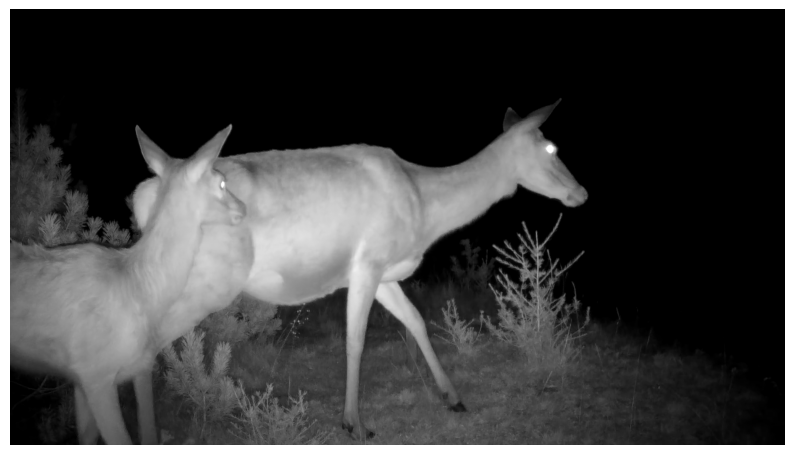

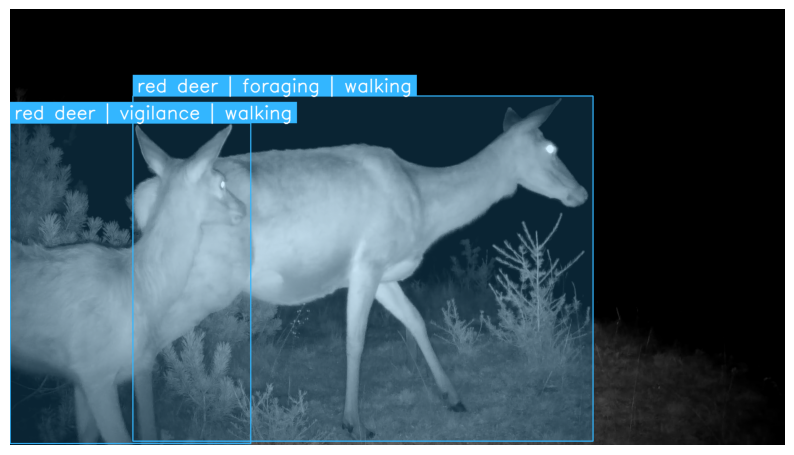

In [8]:
# Supervision annotator objects
color_lookup = sv.ColorLookup("class")
box_annotator = sv.BoxAnnotator(color_lookup=color_lookup, thickness=2)
box_fill_annotator = sv.ColorAnnotator(color_lookup=color_lookup, opacity=0.2)
label_annotator = sv.LabelAnnotator(text_scale=1.5, color_lookup=color_lookup, text_thickness=2)

# Extracting frame of interest
cap = cv2.VideoCapture(str(video_path))
cap.set(cv2.CAP_PROP_POS_FRAMES, 279)
res, frame = cap.read()

# Plotting the original frame
plt.figure(figsize=(10,12))
plt.imshow(frame, aspect="equal")
plt.axis("off")
plt.show()

# Annotating detection boxes and labels
labels = []
for tracker_id in range(len(detection_sv.tracker_id)):
    labels.append(
        " | ".join(
            str(detection_sv.data[l][tracker_id])
            for l in detection_sv.data
            if detection_sv.data[l][tracker_id] != "none"
        ).replace("_", " ")
    )

annotated_frame = box_annotator.annotate(
    scene=frame.copy(), detections=detection_sv
)
annotated_frame = box_fill_annotator.annotate(
    scene=annotated_frame, detections=detection_sv
)
annotated_label_frame = label_annotator.annotate(
    scene=annotated_frame, detections=detection_sv, labels=labels
)

# Plotting the annotated frame
plt.figure(figsize=(10,12))
plt.imshow(annotated_frame, aspect="equal")
plt.axis("off")
plt.show()

In [9]:
# This function is adapted from the visualization script and outputs a video containing the annotations for every frame
def process_video(
    source_video_path: str,
    detection_results: Dict,
    target_video_path: str,
    color_by: str,
) -> None:
    """
    Processes a single video by annotating it with detection results and saving the output.

    Args:
        source_video_path (str): Path to the input video file.
        detection_results (Dict): Dictionnary containing the frame annotations.
        target_video_path (str): Path to save the annotated video.
        color_by (str): Specifies the attribute to use for coloring the bounding boxes
                        (e.g., "action", "action2", "activity", "individual").

    Returns:
        None
    """

    color_lookup = sv.ColorLookup("class")
    frame_generator = sv.get_video_frames_generator(source_path=source_video_path, stride=1)
    video_info = sv.VideoInfo.from_video_path(video_path=source_video_path)

    frame_idx = 0
    with sv.VideoSink(target_path=target_video_path, video_info=video_info, codec="mp4v") as sink:
        for frame in tqdm(frame_generator, total=video_info.total_frames):

            # Retrieve the list of detections for the current frame
            if len(detection_results[frame_idx]["detections"]) > 0:
                detections = supervision_from_json(detection_results[frame_idx], color_by=color_by)

                # Prepare labels
                labels = []
                for tracker_id in range(len(detections.tracker_id)):
                    labels.append(
                        " | ".join(
                            str(detections.data[l][tracker_id])
                            for l in detections.data
                            if detections.data[l][tracker_id] != "none"
                        ).replace("_", " ")
                    )

                # Annotating detection boxes
                annotated_frame = box_annotator.annotate(
                    scene=frame.copy(), detections=detections
                )
                annotated_frame = box_fill_annotator.annotate(
                    scene=annotated_frame, detections=detections
                )

                # Annotating labels
                annotated_label_frame = label_annotator.annotate(
                    scene=annotated_frame, detections=detections, labels=labels
                )
            else:
                # If no annotation for this frame
                annotated_label_frame = frame.copy()

            # Add frame number on top left corner
            annotated_label_frame = cv2.putText(
                annotated_label_frame,
                str(frame_idx),
                org=(10, 20),
                color=(255, 255, 255),
                fontFace=1,
                fontScale=2,
            )
            sink.write_frame(frame=annotated_label_frame)

            frame_idx += 1

In [10]:
target_video_path= "./" + (Path(video_path).stem + "_annotated.mp4")
process_video(source_video_path=str(video_path), detection_results=annotations["frames"], target_video_path=str(target_video_path), color_by="action")

  0%|          | 0/615 [00:00<?, ?it/s]

In [11]:
# (Opt.) we re-encode the video with the libx264 codec to visulize in jupyter notebook
reencoded_target = "./" + str(Path(target_video_path).stem + "_codec.mp4")

out, _ = (
    ffmpeg.input(str(target_video_path))
    .output(reencoded_target, vcodec="libx264")
    .overwrite_output()
    .run(capture_stdout=True, quiet=True)
)

Video(reencoded_target, width=920, height=540)